In [7]:
#preparing feedback data paths over time for GP practices

import pandas as pd
import numpy as np
import os
import iisignature
import time
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt

def make_paths(csv_file, min_day=None, max_day=None, depvar= "q9", ignore_nan = True):
    """
    
    Makes paths from panel data. Paths can be used to compute signatures and log signatures
    
    make_paths returns a dictionary with paths of records over time for each data point
    (e.g. a data point is feedback about a GP practice over time)
    
    inputs:
        - "csv_file" (str): name of .csv-formatted file containing topic proportions for each message
        - min_day (int): first cut-off day from which reviews are considered. First day of year 0 AD equals to 1, 
                        second day of that year equals to 2, and so on. Default value is "None" (i.e. all dates 
                        when feedback was posted apply)
        - max_day (int): last cut-off day tu which reviews are considered. First day of year 0 AD equals to 1, 
                        second day of that year equals to 2, and so on. Default value is "None" (i.e. all dates 
                        when feedback was posted apply)
        - depvar (str): name of dependent variable to be considered when constructing the paths. Reviews which don't
                        contain this variable will be ignored. If more than one review is posted at a given day (very 
                        low likelihood of this), feedback scores are averaged for the given day.
        - ignore_nan (logical): whether to exclude reviews which have no value for the dependent variable. Reviews with
                        a missing dependent variable are excluded by default
                        NOTE: If reviews with missing dependent variable are to be included in the output of this 
                        function, the make_sigs() function will only run without error if parameter include_depvar 
                        is set to False.
    
    output:
        The function returns a dictionary where each entry corresponds to a GP practice. Dictionary values are lists
        with all feedback that was posted about the GP practice, ordered according to the day of posting. 
        Information about the oldest review comes first, the second oldest second, and so on. 
    
    
    Example:
    
    # A dataset contains feedback about a GP practice with ID number 1000, where reviewers provided 
    # Likert-scale response to question 10, i.e. "Do the staff treat you with dignity and respect?" 
    # Likert-scale responses are the dependent variable.
    
    paths = make_paths("my_demo_data.csv", depvar= "q10.numeric")
    
    # There are two reviews about this GP practice which were posted in days 7000 and 8200
    # In addition, the oldest reviews in "my_demo_data.csv" are from day 6000. 
    
    for review in paths[1000]: #this would print the two reviews about GP practice with ID 1000
        print(review)
    
    # The print() function returns:
    
    [array(7000), array(1.0), array(0.23), array(0.58), array(0.19), array(1.0), array(1000)]
    [array(8200), array(4.0), array(0.73), array(0.13), array(0.14), array(1.0), array(1200)]
    
    # review from day 7000 had Likert-scale response 1 (i.e. 1 our of 5 stars)
    # 23% of it were positive topics, 58% were negative topics, and 19% were neutral topics
    # 1 review was posted on that day, and it was posted 1000 days after the oldest reviews in "my_demo_data.csv".
    
    # review from day 8200 had Likert-scale response 4 (i.e. 4 our of 5 stars)
    # 73% of it were positive topics, 13% were negative topics, and 14% were neutral topics
    # 1 review was posted on that day, and it was posted 1200 days after the last review of this GP practice


    To do:
        Making this function faster is key to making elastic net computation faster.
    """
    df = pd.read_csv(csv_file)
    
    if depvar in list(df) and depvar[0] == 'q':
        depvar = list(df).index(depvar)
    else:
        print("WARNING: check the column name for your dependent variable. The one you provided doesn't exist")
        return(None)
    
    df = df.values.tolist()
    
    #setting min and max dates if none were provided for either 
    if min_day == None or max_day == None:
        df2 = [x[2] for x in df]
        if min_day == None:
            min_day = min(df2)
        if max_day == None:
            max_day = max(df2)

    sciezki = {}
    stopnie = [list() for x in range(min_day,max_day+1)]
    for i,v in enumerate(df):
        if int(v[2]) >= min_day and v[2] <= max_day:
            if np.isnan(v[depvar]) == True and ignore_nan == True:
                continue
            if v[1] in sciezki:
                d = int(v[2]) - min_day
                temp = [d]
                temp.append(v[depvar])
                temp.append(1)
                temp.extend(v[10:])
                v2 = sciezki[v[1]][:]
                temp = [np.array(float(x)) for x in temp]
                if len(v2[d]) == 0:
                    v2[d] = temp
                    sciezki[v[1]] = v2
                else:
                    temp2 = [v2[d][0]]
                    weight_old = v2[d][2]/(v2[d][2] + 1)
                    weight_new = 1 - weight_old
                    indeksy = list(range(1,len(temp)))
                    for x in indeksy:
                        if x != 2:
                            xx = v2[d][x]*weight_old + temp[x]*weight_new
                            temp2.append(np.array(xx))
                        else:
                            temp2.append(np.array(v2[d][2]+1))
                    v2[d] = temp2
                    sciezki[v[1]] = v2
            else:
                d = int(v[2]) - min_day
                v2 = stopnie[:]
                temp = [d]
                temp.append(v[depvar])
                temp.append(1)
                temp.extend(v[10:])
                v2[d] = [np.array(float(x)) for x in temp]
                sciezki[v[1]] = v2
    
    del df

    # delete empty lists from CCG paths. 
    # Add variable informing time distance from last available period
    to_pop = []
    for x in sciezki:
        temp = sciezki[x]
        temp2 = []
        l = 0        
        for i,y in enumerate(temp):
            if len(y) == 0:
                l = l + 1
            else:
                y.append(np.array(l))
                temp2.append(y)
                l = 1

        sciezki[x] = temp2
        if len(temp2) < 2: # paths can only be computed if there are at least 2 records in the path
            to_pop.append(x)
            
    for x in to_pop:
        sciezki.pop(x)
    return sciezki

paths = make_paths('r_output.csv',depvar='q9', min_day=735008)

print('ok')

ok


In [8]:
"""

paper 2 - GP-level elastic net prediction (NO SIGNATURES USED)

Computing elastic model separately for each GP practice in the dataset


Given data are available up to mid December 2017, models are trained to predict feedback for September 
and October 2017. Model testing takes place for feedback in November and December 2017. Models are trained and
tested for GP practices which:
    - have at least 2 reviews from period preceding September 2017
    - received some feedback in September or October 2017
    - received some feedback in November and December 2017

"""

# paths = make_paths('r_output.csv',depvar='q9')



# def avg_as_pred(paths,train_range,test_range):
#     """
    
#     Computes average depvar score. 
    
#     """
    
#     pass
    


def weights(start_date,end_date, k=1, t=20):
    """
    returns weights of data points according to how much time has elapsed from the most recent month.
    First value of w2 is the first available month (lowest weight), second value is second second available month,...
    and last value of w2 is the last available month (greatest weight).
    
    inputs:
        start_date (int) - first date expressed numerically
        end_date (int) - last date expressed numerically
        k (int) - scaling constant
        t (int) - time-constant for decay
        
    output:
        list of weights. First position is the weight of data point from start_date. Data point
        on start_date has the smallest weight
    
    example use:
    w = weights(735008,736620,t=1450)
    
    """
    w = np.ones(len(list(range(start_date,end_date+1))))
    w2 = []
    for time_elapsed, v in enumerate(w):
        weight = k*math.exp(-time_elapsed/t)
        w2.append(weight)
    
    w2 = list(reversed(w2))
    return w2

    
def gp_elnet_pred2(paths, train = None, test = None, depvar='q9', day_min = 735008, folds = 5, seed = 1, time_factor=800, verbose=False):
    
    """
    
    Computes a separate elastic net model for each individual GP practice which:
        - has received at least 2 reviews (or a number of reviews equal to the number of cross-validation folds) from 
            a period preceding 'train' and 'test'
        - has received some reviews within 'train'
        - has received some reviews within 'test'
    
    Notes:
        - It is expected that 'train' predates 'test' and that the two periods are non-overlapping.
        - reviews are weighted to matter less for prediction the more distant in time they are from the predicted time
    
    
    inputs:
        - paths (dict): paths of feedback collected over time. Output of make_paths() function
        - train (list with 2 integers): time period expressed in day numbers from which 
            dependent variable data are used for model training
        - test (list with 2 integers): time period
        - depvar (str): name of column in .csv file used to make the paths which serves as the source of dependent
                variable data. The default value is 'q9'
        - day_min (int)
        - folds (int): number of folds used for elastic net cross-validation. The default is 5
        - seed (int): number selecting quasi random choice of data points for train and test sets in elastic net
                cross-validation. 'seed = None' means that each elastic net cross-validation will take in different
                choices of training and test sets of data points. The default value for seed is 1

    output:
        - trained elastic net models for each GP practice according to set model parameters
        - elastic net cross-validation outcomes for test and train datasets
    
    Example:
    
    
    """
    
    if test == None and test == train:
        test = list(range(736621,736681))
        train = list(range(day_min,736621))
    elif type(test) == list and type(train) == list:
        if len(test) == 0 or len(train) == 0:
            print('TypeError: test and train should be non-empty lists of day ID numbers')
            return()
    else:
        print("TypeError: define test and train attributes or leave default values, i.e. None")
        return()
    
    # test for overlap of train_range and test_range
    if min(test) <= max(train):
        print("AttributeError: select non-overlapping ranges of days for test and train. Also, days included in train should pre-date days included in test")
        return()
    
    # test whether day_min is prior to day ranges defined in y_train and y_test
    if day_min >= min(test) or day_min > min(train):
        print("AttributeError: select ranges of days for test and train which post-date day_min")
        return()
    
    # test how many GP practices have enough feedback to train and test the elastic net model
    # a data point (a review) counts if there are reviews within [max(test)-min(test)] days after feedback is posted
    # furthermore, a GP practice can have a trained model if there is independent variable feedback from within [max(test)-min(test)] days prior to the test period
    gp_mods = 0
    total = 0
    train_koniec = max(train) - day_min # reviews from only preceding dates are included in model training
    test_start = min(test) - day_min # this and later dates are included in model testing
    test_koniec = max(test) - day_min # reviews from only preceding dates are included in model testing
    window = max(test) - min(test) + 1
    
    x_min = 1
    if folds > x_min + 1:
        x_min = folds - 1
        if verbose == True:
            print("minimum number of data points for model training has been updated to " + str(x_min+1) + " from initial 2. Number of data points has to at least be equal to the number of model cross-validation folds")
            print()
    
    gp_dict = {}
    for nr, gp in enumerate(paths):
        if nr < 300000000000: # sample size can be determined here, if needed for exercise
            gp_train = []
            gp_test = []
            gpgp = paths[gp]

            x_scope = [0,59]
            y_scope = [60,119]
            tmp_xdict = {}
            tmp_ydict = {}
            for x in gpgp:
                if x[0] <= train_koniec:
                    x_scope = [x[0]- window*2 + 1,x[0] - window]
                    y_scope = [x[0] - window + 1, x[0]]
                    
                    tmp_ydict[int(x[0])] = x
                    
                    for key in list(tmp_ydict):
                        if key < y_scope[0]:
                            tmp_xdict[key] = tmp_ydict[key]
                            tmp_ydict.pop(key)
                    for key in list(tmp_xdict):
                        if key < x_scope[0]:
                            tmp_xdict.pop(key)
                    
                    if len(list(tmp_xdict)) > 0 and len(list(tmp_ydict)) > 0:
                        tmp_xdf = pd.DataFrame.from_dict(tmp_xdict)
                        avg_x = tmp_xdf.mean(axis=1)
                        tmp_ydf = pd.DataFrame.from_dict(tmp_ydict)
                        avg_y = tmp_ydf.mean(axis=1)
                        
                        row = [list(avg_x)[0]]
                        row.append(list(avg_y)[1])
                        row.extend(list(avg_x)[2:])
                        
                        gp_train.append(row)

                if x[0] >= test_start and x[0] < test_koniec:
                    x_scope = [test_start-window,test_koniec-window]
                    y_scope = [test_start,test_koniec]

                    tmp_ydict[int(x[0])] = x

                    for key in list(tmp_ydict):
                        if key < y_scope[0]:
                            tmp_xdict[key] = tmp_ydict[key]
                            tmp_ydict.pop(key)
                    for key in list(tmp_xdict):
                        if key < x_scope[0]:
                            tmp_xdict.pop(key)
                            
            if len(tmp_xdict) > 0 and len(tmp_ydict) > 0:
                tmp_xdf = pd.DataFrame.from_dict(tmp_xdict)
                avg_x = tmp_xdf.mean(axis=1)
                tmp_ydf = pd.DataFrame.from_dict(tmp_ydict)
                avg_y = tmp_ydf.mean(axis=1)
                row = [list(avg_x)[0]]
                row.append(list(avg_y)[1])
                row.extend(list(avg_x)[2:])
                gp_test.append(row)


            if len(gp_test) >= 1 and len(gp_train) > x_min:
                gp_dict[gp] = [gp_train, gp_test]
                gp_mods = gp_mods + 1
                total = total + 1
            else:
                total = total + 1

    if verbose == True:
        print('Elastic models are being computed for ' + str(gp_mods) + ' GP practices out of ' + str(total) 
              + " for which feedback is available. GP practices without model had fewer than " + str(x_min+1) 
              + " reviews available for model training and/or no reviews for model testing")
        print()
    
    data_weights = weights(min(train),max(train),t=time_factor)
    regr = ElasticNetCV(cv=folds, random_state=seed)
    
    
    x_cols = len(gp_dict[list(gp_dict.keys())[0]][0][0])
    x_cols = list(range(x_cols-1))
    del x_cols[1]
    columns = ['beta' + str(x) for x in range(len(x_cols))]
    columns.insert(0, 'gp_id')
#     tmp = ['mse' + str(x) for x in range(100)]
#     columns.extend(tmp)
#     tmp = ['alpha' + str(x) for x in range(100)]
#     columns.extend(tmp)
#     elnet_mods = pd.DataFrame(columns=columns) # SAVE MODELS AS A DATAFRAME (ALTERNATIVE)
    elnet_mods = {}
    train_allmods = {}
    test_allmods = {}
    for x in gp_dict:
        train_summary = pd.DataFrame(gp_dict[x][0])
        
        # prepare x_train and y_train. Compute model
        x_train = train_summary.loc[:, x_cols]
        update = list(x_train.loc[:,0])
        del x_train[0]
        update = [data_weights[int(x)] for x in update]
        train_summary['weights'] = update
        x_train = x_train.transpose() * update
        x_train = np.array(x_train.transpose().values.tolist())
        y_train = train_summary.loc[:,1].transpose() * update
        y_train = np.array(y_train.transpose().values.tolist())
        
        elnet_ready = regr.fit(x_train, y_train) # compute elastic_net model
        
        elnet_mods[x] = elnet_ready
        # SAVE MODELS AS A DATAFRAME (ALTERNATIVE)
#         row = [x, elnet_ready.intercept_]
#         row.extend(elnet_ready.coef_)
#         row.extend(elnet_ready.mse_path_)
#         row.extend(elnet_ready.alphas_)
#         elnet_mods.append(row)
        
        #prepare x_test and y_test
        test_summary = pd.DataFrame(gp_dict[x][1])
        x_test = test_summary.loc[:, x_cols]
        del x_test[0]
        x_test = np.array(x_test.values.tolist())
        y_test = np.array(test_summary.loc[:,1].values.tolist())

        #predict values in train and test datasets
        x_train = train_summary.loc[:, x_cols]
        del x_train[0]
        yhat_train = elnet_ready.predict(x_train.values.tolist())
        train_summary['yhat_train'] = yhat_train
        tmp = list(train_summary.columns)
        tmp.insert(2,'yhat_train')
        train_summary = train_summary[tmp[:-1]]
        yhat_test = elnet_ready.predict(x_test)
        test_summary['yhat_test'] = yhat_test
        tmp = list(test_summary.columns)
        tmp.insert(2,'yhat_test')
        test_summary = test_summary[tmp[:-1]]
        
        #update train_allmods and test_allmods
        train_allmods[x] = train_summary
        test_allmods[x] = test_summary
    
    combined_results = [elnet_mods, train_allmods, test_allmods]
    if verbose == True:
        print('models computed')
    return combined_results
    

# comb_res = []
# with warnings.catch_warnings():
# #     warnings.filterwarnings("ignore",category= ConvergenceWarning)

comb_res = gp_elnet_pred2(paths=paths, time_factor=1200)


print("ok")

c:\users\user\envs\radek1\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\envs\radek1\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\envs\radek1\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\envs\radek1\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to in

c:\users\user\envs\radek1\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\envs\radek1\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\envs\radek1\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\envs\radek1\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to in

ok


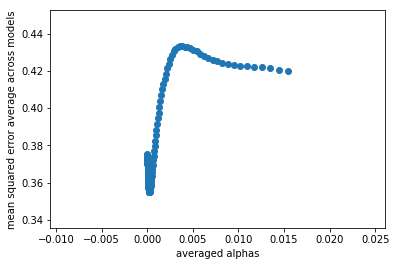

Fitted satisfaction vs actual satisfaction for training variable


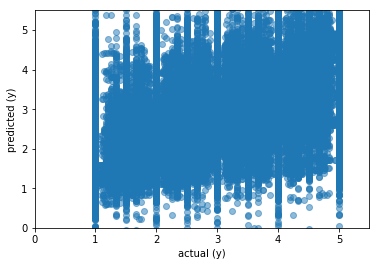

Fitted satisfaction vs actual satisfaction for test variable


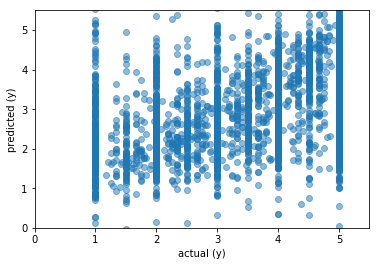

ok


In [10]:
"""

analysis of outputs of the gp_elnet_pred2() function

"""


def metrics2 (combined_results, mse = True, alpha_vs_mse=False, true_vs_predicted=False, no_outlier_plt = True):
    
    """
    
    Get mean squared error and mean absolute errors for elastic net prediction, together with
    a graph showing a plot with elastic net shrinking factor alpha on x-axis and mean squared test 
    errors on y-axis.
    
    Inputs:
        - combined_results (dict): elastic net regression outputs from gp_elnet_pred2() function
        - mse (True/False): whether to output AN AVERAGE OF mean squared errors or mean absolute errors FOR ALL 
        TRAINED ELASTIC NET MODELS. The default is mean squared errors, with 'mse = True'.
        - cv_graph (True/False): whether to output a graph showing a plot with Lasso shrinking factor alpha 
        on x-axis and mean squared test errors on y-axis (A GLOBAL AVERAGE FOR ALL TRAINED ELASTIC NET MODELS) (optional)
        
    Outputs:
        - mean squared or mean absolute errors for the training and test datasets, average for all models
        - plot showing elastic net regression shrinking factor alpha on x-axis and 
        mean squared test errors on y-axis
        - plot showing predicted vs. actual values
    """
        
    #mean squared errors and average errors for training and test data

    train = pd.DataFrame(columns = ['gp_id', 'y_train', 'yhat_train'])
    test = pd.DataFrame(columns = ['gp_id', 'y_test', 'yhat_test'])
    if alpha_vs_mse == True:
        cols = ['mse' + str(x) for x in range(100)]
        cols.insert(0,'gp_id')
        tmp = ['alpha' + str(x) for x in range(100)]
        cols.extend(tmp)  
        mses_and_alphas = []
    
    for nr, key in enumerate(list(combined_results[0])): 
        if nr < 30000000000:
            # prepare data for obtaining average MSE or average MAE
            ['gp_id', 'y_train', 'yhat_train']
            tmp = combined_results[1][key].loc[:, [1,'yhat_train']]
            tmp.columns = ['y_train', 'yhat_train']
            gp = [key for x in tmp.yhat_train]
            tmp['gp_id'] = gp
            tmp = tmp[['gp_id', 'y_train', 'yhat_train']]
            train = pd.concat([train,tmp])
            
            tmp = combined_results[2][key].loc[:, [1,'yhat_test']]
            tmp.columns = ['y_test', 'yhat_test']
            gp = [key for x in tmp.yhat_test]
            tmp['gp_id'] = gp
            tmp = tmp[['gp_id', 'y_test', 'yhat_test']]
            test = pd.concat([test,tmp])
            if alpha_vs_mse == True:
                # prepare data for alpha_vs_mse plot
                row = [np.mean(x) for x in combined_results[0][key].mse_path_]
                row.extend(combined_results[0][key].alphas_)
                row.insert(0,key)
                mses_and_alphas.append(row)

    avg_train = 0
    avg_test = 0
    if mse == True:
        avg_train = mean_squared_error(train['y_train'],train['yhat_train'])
        avg_test = mean_squared_error(test['y_test'],test['yhat_test'])
    else:
        dif_train = train['y_train'] - train['yhat_train']
        dif_abs_train = [abs(x) for x in dif_train]
        avg_train = np.mean(dif_abs_train)
        
        dif_test = test['y_test'] - test['yhat_test']
        dif_abs_test = [abs(x) for x in dif_test]
        avg_test = np.mean(dif_abs_test)
    
    errors = [avg_train,avg_test]
    

    #average_mses vs average_alphas plot
    if alpha_vs_mse == True:
        mses_and_alphas = pd.DataFrame(mses_and_alphas, columns = cols)
        average_mses = [np.mean(mses_and_alphas.loc[:,x]) for x in list(mses_and_alphas)[1:101]]
        average_alphas = [np.mean(mses_and_alphas.loc[:,x]) for x in list(mses_and_alphas)[101:201]]

        plt.scatter(average_alphas, average_mses)
        
        plt.xlabel('averaged alphas')
        plt.ylabel('mean squared error average across models')
        plt.show()
    

    # predictions vs actual values plots
    if true_vs_predicted == True:
        print("Fitted satisfaction vs actual satisfaction for training variable")
        plt.scatter(train['y_train'], train['yhat_train'], alpha=0.5)
        plt.xlabel('actual (y)')
        plt.ylabel('predicted (y)')
        if no_outlier_plt == True:
            axes = plt.gca()
            axes.set_xlim([0,5.5])
            axes.set_ylim([0,5.5])
        plt.show()
        print("Fitted satisfaction vs actual satisfaction for test variable")
        plt.scatter(test['y_test'], test['yhat_test'], alpha=0.5)
        plt.xlabel('actual (y)')
        plt.ylabel('predicted (y)')
        if no_outlier_plt == True:
            axes = plt.gca()
            axes.set_xlim([0,5.5])
            axes.set_ylim([0,5.5])
        plt.show()

    return errors


metrics2(comb_res, mse = True, alpha_vs_mse=True, true_vs_predicted=True)
print('ok')

In [ ]:
# compare alternative settings for t parameter
import warnings
from sklearn.linear_model.coordinate_descent import ConvergenceWarning


t_results = []
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category= ConvergenceWarning)

    t_candidates = [50*x for x in range(1,32)]
    # t_candidates = [50*x for x in range(1,3)]
    questions = ['q9','q10','q11','q12','q13','q14']
    
    for c in t_candidates:
        print('compute results for t=' +str(c))
        combined_results = gp_elnet_pred(paths, train = None, test = None, depvar='q9', day_min = 735008, folds = 5, seed = 1, time_factor=c)
        tt = metrics2(combined_results, mse = True, alpha_vs_mse=False, true_vs_predicted=False)
        t_results.append(tt)

    print('all candidate models completed')

In [ ]:
# plot summary results

x = pd.DataFrame(t_results, columns = ['test_err','train_err'])
x['t_val'] = t_candidates

print("Prediction errors in model training")
plt.plot(x.t_val, x.train_err, 'ro')
plt.xlabel('Weight discount of older reviews (lower value => greater discount)')
plt.ylabel('average mean squared error')
plt.show()

print("Prediction errors in model testing")
plt.plot(x.t_val, x.test_err, 'ro')
plt.xlabel('Weight discount of older reviews (lower value => greater discount)')
plt.ylabel('average mean squared error')
plt.show()